In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,node_count_scoring_3,node_count_scoring_4,real,original_game_name,all_variables_defined,all_variables_used,...,node_count_constraints_3,node_count_constraints_4,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,0,0,1,6172feb1665491d1efbce164-0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,0,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,0,0,1,614b603d4da88384282967a7-3,1.0,1.0,...,0,0,1,0,0,0,0,0,1,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,0,0,1,5bc79f652885710001a0e82a-5,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,0,0,1,614dec67f6eb129c3a77defd-6,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [5]:
[c for c in fitness_df.columns if '(:' in c]

[]

In [6]:
def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [7]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,node_count_scoring_3,node_count_scoring_4,real,original_game_name,all_variables_defined,all_variables_used,...,node_count_constraints_3,node_count_constraints_4,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,0,0,1,6172feb1665491d1efbce164-0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,0,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,0,0,1,614b603d4da88384282967a7-3,1.0,1.0,...,0,0,1,0,0,0,0,0,1,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,0,0,1,5bc79f652885710001a0e82a-5,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,0,0,1,614dec67f6eb129c3a77defd-6,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [8]:
filtered_fitness_df[['real'] + [c for c in filtered_fitness_df.columns if c.endswith('_expression_found')]].groupby('real').mean()

,tautological_expression_found,redundant_expression_found
real,,
0,0.021524,0.143415
1,0.000000,0.051020


In [9]:
display(Markdown(filtered_fitness_df.iloc[:, [4] + list(range(18, 20)) + [21, 22, 23]].groupby('real').mean(numeric_only=True).to_markdown()))

KeyError: 'real'

In [ ]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.29% of the games, the regrown game was identical to the original game.


In [ ]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

print(sum(never_change))

section_without_pref_or_total_count_terminal
section_without_pref_or_total_count_scoring
arg_types_adjacent_agent_agent_setup
arg_types_adjacent_agent_any_object_setup
arg_types_adjacent_agent_balls_setup
arg_types_adjacent_agent_blocks_setup
arg_types_adjacent_agent_colors_setup
arg_types_adjacent_agent_building_setup
arg_types_adjacent_agent_large_objects_setup
arg_types_adjacent_agent_orientations_setup
arg_types_adjacent_agent_orientations_constraints
arg_types_adjacent_agent_ramps_setup
arg_types_adjacent_agent_room_features_setup
arg_types_adjacent_agent_sides_setup
arg_types_adjacent_agent_sides_constraints
arg_types_adjacent_agent_small_objects_setup
arg_types_adjacent_any_object_agent_setup
arg_types_adjacent_any_object_balls_setup
arg_types_adjacent_any_object_blocks_setup
arg_types_adjacent_any_object_colors_setup
arg_types_adjacent_any_object_building_setup
arg_types_adjacent_any_object_large_objects_setup
arg_types_adjacent_any_object_large_objects_constraints
arg_types_ad

# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    feature_columns=all_feature_columns, scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)  #, histogram_title_note='with `real` flag')

In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [ ]:
# cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
utils.evaluate_energy_contributions(cv, train_tensor, 3621, feature_columns, full_tensor, real_game_texts, regrown_game_texts, top_k=5)

### Trying with binarized features

In [23]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_or_total_count_terminal', 'section_without_pref_or_total_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations',
    'tautological_expression_found', 'redundant_expression_found',
]  

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+')
]   


def _update_single_series(series: pd.Series, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS):
    c = str(series.name)
    if c in ignore_columns:
        return series

    if c in BINARIZE_IGNORE_FEATURES:
        return series
    
    if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
        return series

    if c in BINARIZE_NON_ONE:
        return (series == 1).astype(int)

    if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
        return (series != 0).astype(int)
    
    raise ValueError(f'No binarization rule for column {c}')


def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.apply(_update_single_series, axis=0, ignore_columns=ignore_columns)
    return binarized_df


binarized_df = binarize_features(fitness_df)
binarized_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


## Trying the binarized square-square

Train tensor shape: torch.Size([78, 129, 7989]) | Test tensor shape: torch.Size([20, 129, 7989])
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Test results:

{'ecdf': -0.2822093023255814, 'game_rank': 0.8433593511581421}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
316,2,64,<function fitness_square_square_loss at 0x15ce...,0.003,8,7989,0.0,-0.317007,0.015563,1,0.843724,0.013451,1
312,2,64,<function fitness_square_square_loss at 0x15ce...,0.003,4,7989,0.0,-0.322460,0.017366,2,0.839160,0.010750,2
940,8,64,<function fitness_square_square_loss at 0x15ce...,0.010,8,7989,0.0,-0.323399,0.013726,3,0.832786,0.011068,5
248,2,32,<function fitness_square_square_loss at 0x15ce...,0.003,4,7989,0.0,-0.325491,0.019098,4,0.834323,0.014021,4
252,2,32,<function fitness_square_square_loss at 0x15ce...,0.003,8,7989,0.0,-0.327226,0.019580,5,0.838685,0.012399,3
876,8,32,<function fitness_square_square_loss at 0x15ce...,0.010,8,7989,0.0,-0.327540,0.020032,6,0.826712,0.019027,16
936,8,64,<function fitness_square_square_loss at 0x15ce...,0.010,4,7989,0.0,-0.328219,0.010208,7,0.823542,0.018229,82
308,2,64,<function fitness_square_square_loss at 0x15ce...,0.003,2,7989,0.0,-0.328320,0.021358,8,0.828542,0.016198,6
636,4,64,<function fitness_square_square_loss at 0x15ce...,0.003,8,7989,0.0,-0.330465,0.015645,9,0.820404,0.010226,107
244,2,32,<function fitness_square_square_loss at 0x15ce...,0.003,2,7989,0.0,-0.331094,0.014857,10,0.826647,0.014848,17


### CV results by mean single game rank:

fitness__batch_size  fitness__k  \
316                     2          64   
312                     2          64   
252                     2          32   
248                     2          32   
940                     8          64   
308                     2          64   
1222                   16          64   
1223                   16          64   
1218                   16          64   
1219                   16          64   

                                 fitness__loss_function  fitness__lr  \
316   <function fitness_square_square_loss at 0x15ce...        0.003   
312   <function fitness_square_square_loss at 0x15ce...        0.003   
252   <function fitness_square_square_loss at 0x15ce...        0.003   
248   <function fitness_square_square_loss at 0x15ce...        0.003   
940   <function fitness_square_square_loss at 0x15ce...        0.010   
308   <function fitness_square_square_loss at 0x15ce...        0.003   
1222  <function fitness_square_square_loss at 0x15ce...        0.100   
1223  <function fitness_square_square_loss at 0x15ce...        0.100   
1218  <function fitness_square_square_loss at 0x15ce...        0.100   
1219  <function fitness_square_square_loss at 0x15ce...        0.100   

      fitness__margin  fitness__n_features  fitness__weight_decay  ecdf_mean  \
316                 8                 7989                    0.0  -0.317007   
312                 4                 7989                    0.0  -0.322460   
252                 8                 7989                    0.0  -0.327226   
248                 4                 7989                    0.0  -0.325491   
940                 8                 7989                    0.0  -0.323399   
308                 2                 7989                    0.0  -0.328320   
1222                2                 7989                    1.0  -0.420201   
1223                2                 7989                    2.0  -0.420185   
1218                1                 7989                    1.0  -0.420215   
1219                1                 7989                    2.0  -0.420197   

      ecdf_std  ecdf_rank  game_rank_mean  game_rank_std  game_rank_rank  
316   0.015563          1        0.843724       0.013451               1  
312   0.017366          2        0.839160       0.010750               2  
252   0.019580          5        0.838685       0.012399               3  
248   0.019098          4        0.834323       0.014021               4  
940   0.013726          3        0.832786       0.011068               5  
308   0.021358          8        0.828542       0.016198               6  
1222  0.012343        309        0.827956       0.014461               7  
1223  0.012198        306        0.827786       0.012216               8  
1218  0.012200        310        0.827598       0.012247               9  
1219  0.012165        308        0.827493       0.011860              10

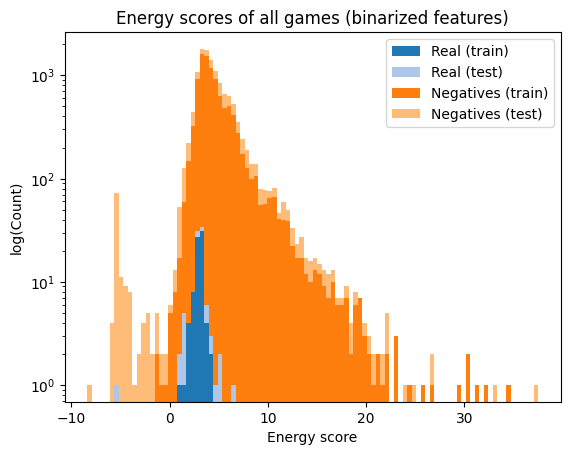

0.0073428648 0.10717842 1.7244049


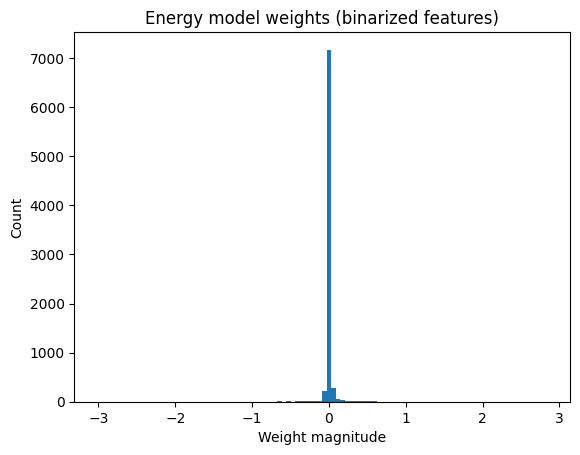

In [24]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_no_scaling_sq_sq, (train_tensor_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq), test_results_no_scaling_sq_sq = utils.model_fitting_experiment(binarized_df, test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_no_scaling_sq_sq, train_tensor_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, test_results_no_scaling_sq_sq, histogram_title_note='binarized features')

In [ ]:
SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_binarized_sq_sq_model_2023_01_26.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv_no_scaling_sq_sq.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

### Checking the effect of regrowth depth

In [ ]:
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_binarized_tensor = utils.df_to_tensor(binarized_df, feature_columns)
full_tensor_scores = cv_no_scaling_sq_sq.best_estimator_.transform(full_binarized_tensor).detach()

In [ ]:
energy_diffs = full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)
energy_diffs.ravel().shape

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 2:]
    return int(regrowth_depth)

regrowth_depts = [extract_regrowth_depth(g) for g in regrown_game_texts]

In [ ]:
plt.scatter(regrowth_depts, energy_diffs.ravel().numpy(), s=5)

In [ ]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

In [ ]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [ ]:
weight_threshold = 1
weights = cv_no_scaling_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
weights_above_threshold = (weights.abs() > weight_threshold).numpy()
feature_columns = [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
features_with_weight_above_threshold = [feature_columns[i] for i in range(len(feature_columns)) if weights_above_threshold[i]]

with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'w') as f:
    f.write('\n'.join(features_with_weight_above_threshold))
    


In [ ]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [ ]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

In [ ]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

In [ ]:
utils.evaluate_energy_contributions(
    cv_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, 1036,
    feature_columns, full_binarized_tensor, real_game_texts, regrown_game_texts,
)

* **TODO**: why is `(not 10)` a valid expression??

In [11]:
from src import ast_parser
from ast_parser import ASTBooleanParser
from src import fitness_features
from src.fitness_ngram_models import TextNGramModel
featurizer = fitness_features.build_fitness_featurizer(None)

In [12]:
_ = [featurizer.parse(a, 'real-games') for a in game_asts]

In [14]:
d = featurizer.to_df()

In [15]:
len(d.columns)

2123

In [17]:
d.head()

,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,...,text_ngram_0,text_ngram_1,text_ngram_2,text_ngram_3,text_ngram_4,text_ngram_5,text_ngram_6,text_ngram_7,text_ngram_8,text_ngram_9
0,real-games,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,1.0,...,0,0,1,1,0,0,0,0,0,0
1,real-games,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,2,2,0,1,0,1,1,0,1,1
2,real-games,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,real-games,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,1.0,...,1,1,1,1,0,1,1,0,1,0
4,real-games,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,1.0,...,2,2,0,1,0,2,2,0,2,0


In [42]:
[c for c in d.columns if '(:' in c]

[]

In [ ]:
d.index[d.redundant_expression_found != 0]

In [ ]:
d.loc[56, :]

In [ ]:
t = regrown_game_texts[631]
a = grammar_parser.parse(t)
r = featurizer.parse(a, '', True)

In [ ]:
import boolean
import string



In [ ]:
n = 10
algebra = boolean.BooleanAlgebra()
e = algebra.parse('|'.join(string.ascii_lowercase[:n]))

%timeit fitness_features.BOOLEAN_PARSER.evaluate_redundancy(e)

In [ ]:
n = 16
algebra = boolean.BooleanAlgebra()
e = algebra.parse('|'.join(string.ascii_lowercase[:n]))

%timeit fitness_features.BOOLEAN_PARSER.evaluate_redundancy(e)

In [ ]:
n = 20
algebra = boolean.BooleanAlgebra()
e = algebra.parse('|'.join(string.ascii_lowercase[:n]))

%timeit fitness_features.BOOLEAN_PARSER.evaluate_redundancy(e)

* list-comp: 87.2, 177, 269
* generator-expr: 93.7, 176, 253
* loop: 87.3, 176, 258

In [34]:
len([c for c in binarized_df.columns if c.startswith('arg_types_adjacent') and (c.endswith('_setup'))])

196

In [37]:
r = defaultdict(int)

start_index = len('arg_types_')

for c in binarized_df.columns:
    if c.startswith('arg_types'):
        pred = c[start_index:c.find('_', start_index)]
        r[pred] += 1

r

defaultdict(int,
            {'adjacent': 392,
             'agent': 28,
             'between': 5488,
             'distance': 392,
             'in': 420,
             'object': 392,
             'on': 392,
             'touch': 392})